# Verifica delle performance della rete sul Test set
In questo notebook vado a caricare lo stato del modello migliore ottenuto, a partire dai dati salvati nel file riassunto_modelli.txt, e verifico le perfomance del mio modello. Per questo modello vado a raccogliere i dati per realizzare poi una matrice di confusione e vari grafici sulle statistiche di precision, recall, F1-score e accuracy

In [28]:
import torch
import torch.nn as nn
import os

from utils_test import find_best_model_from_summary, compute_pixel_confusion_matrix, plot_pr_curve

from model import UNET 
import utils 
import dataset
import torch.utils.data as data

import warnings
from rasterio.errors import NotGeoreferencedWarning

Per la fase di test non utilizzo la GPU ma vado ad utilizzare la CPU, poiché la potenza di calcolo necessaria è molto inferiore e le operazioni svolte in questa fase sono molte di meno rispetto alla fase di training.

In [29]:
device = torch.device("cpu")
print(f"Dispositivo utilizzato: {device}")

# Percorso al file di riepilogo globale
SUMMARY_FILE_PATH = "output/stats/riassunto_modelli.txt"

# Directory radice dove sono salvati i checkpoint dei run
CHECKPOINT_DIR = "output/checkpoints/" 

Dispositivo utilizzato: cpu


Attraverso la funzione find_best_model_from_summary vado a ricercare nel file riassunto_modelli.txt quale è il modello che ha avuto l'F1-score migliore e vado a caricare tutti i suoi parametri nel dizionario best_model_params.

In [30]:
print("Cercando il modello migliore nel file di riepilogo...")
best_run_id, best_f1_score, best_model_params = find_best_model_from_summary(filepath=SUMMARY_FILE_PATH)

if best_run_id is None:
    print("Impossibile trovare un modello migliore. Assicurati che il file di riepilogo esista e sia popolato.")
    exit()


Cercando il modello migliore nel file di riepilogo...
Lettura del file: output/stats/riassunto_modelli.txt

Analisi completata. Il modello migliore è:
  RUN_ID (Model Name): UNET_0
  Best F1-score: 0.7289
  Parametri di Configurazione del modello migliore: {'MODEL_NAME': 'UNET_0', 'NETWORK_TYPE': 'UNET', 'IN_CHANNELS': 3, 'OUT_CHANNELS': 1, 'LR': 0.0001, 'BATCH_SIZE': 16, 'OPTIMIZER': 'Adam', 'LOSS_FUNCTION': 'BCEWithLogitsLoss', 'MAX_EPOCHS': 16}


In [31]:
MEAN = [0, 0, 0]
STD = [1.0, 1.0, 1.0]
INITIAL_LR = 1e-4 
MAX_LR = 1e-2
SIZE = 200
NUM_WORKERS = 8
BATCH_SIZE = 4 # o 32
EPOCHS = 16
LOAD_BEST = True

# Percorsi utili
DATASET_PATH = "data/train/AOI_11_Rotterdam/"
OUTPUT_PATH = "output/"
CHECKPOINT_PATH = OUTPUT_PATH + "checkpoints/"
GRAPH_PATH = OUTPUT_PATH + "graphs/"
SPLIT_PATH = "split/"
TEST_PATH = OUTPUT_PATH + "test/"

Vado a caricare il modello migliore e a costruire la rete che utilizzerò per testare il modello.

In [32]:
BEST_MODEL_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, best_run_id, "best.pth")

# Questi saranno usati per inizializzare il modello UNET
IN_CHANNELS = best_model_params.get('IN_CHANNELS') 
OUT_CHANNELS = best_model_params.get('OUT_CHANNELS') 

print(f"\nCaricamento del modello migliore: '{best_run_id}' da '{BEST_MODEL_CHECKPOINT_PATH}'")
model = UNET(in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS).to(device)

try:
    checkpoint = torch.load(BEST_MODEL_CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval() # Imposta il modello in modalità valutazione
    print("Modello caricato e impostato in modalità valutazione.")
except FileNotFoundError:
    print(f"Errore: Il file del checkpoint '{BEST_MODEL_CHECKPOINT_PATH}' non è stato trovato.")
    # exit() # Esci se il modello non può essere caricato
except Exception as e:
    print(f"Errore durante il caricamento del modello: {e}")
    # exit()

print(f"Parametri di configurazione del modello migliore: {best_model_params}")




Caricamento del modello migliore: 'UNET_0' da 'output/checkpoints/UNET_0/best.pth'
Modello caricato e impostato in modalità valutazione.
Parametri di configurazione del modello migliore: {'MODEL_NAME': 'UNET_0', 'NETWORK_TYPE': 'UNET', 'IN_CHANNELS': 3, 'OUT_CHANNELS': 1, 'LR': 0.0001, 'BATCH_SIZE': 16, 'OPTIMIZER': 'Adam', 'LOSS_FUNCTION': 'BCEWithLogitsLoss', 'MAX_EPOCHS': 16}


Caricamento del test set e ultimi preparativi riguardo il modello.

Image shape: torch.Size([4, 3, 200, 200]), Mask shape: torch.Size([4, 1, 200, 200])


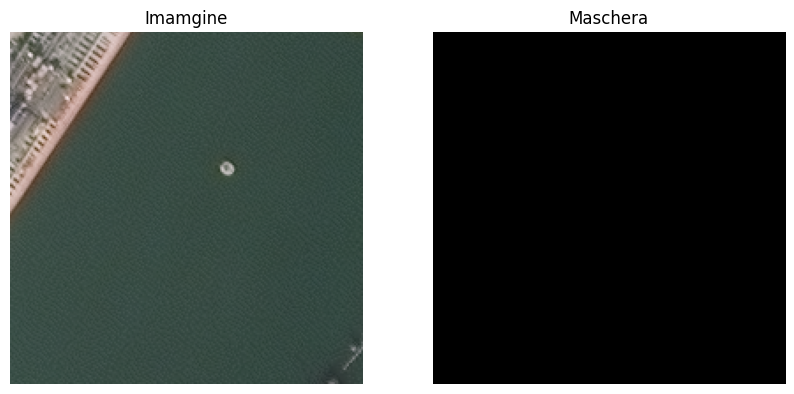

In [33]:
import albumentations as A

# Trasformazioni per il test set (deterministiche)
test_transforms = A.Compose([
    A.Normalize(MEAN, STD, max_pixel_value=255.0),
    A.CenterCrop(height=SIZE, width=SIZE, p=1.0),
    A.Resize(SIZE, SIZE)
])

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    test_dataset = dataset.SpaceNet6Dataset(SPLIT_PATH, transform=test_transforms, split='test')
    test_loader = data.DataLoader(test_dataset, pin_memory = True, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    image, mask = next(iter(test_loader))
    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
    utils.visualize_image(image[0], mask[0])

# Funzione di loss
criterion = nn.BCEWithLogitsLoss()

Calcolo delle statistiche sul Test set.

In [34]:
print("\nInizio la valutazione sul Test Set...")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    test_loss, test_precision, test_recall, test_f1, test_accuracy = utils.get_evals(
        test_loader, model, criterion, device,
        save_predictions=True,
        output_path="test_predictions_of_best_model/" # Cartella specifica per le predizioni del modello migliore
    )

print("\n--- Risultati Finali sul Test Set ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




Inizio la valutazione sul Test Set...
Predizioni salvate in: test_predictions_of_best_model/

--- Risultati Finali sul Test Set ---
Test Loss: 0.1473
Test Precision: 0.7613
Test Recall: 0.7003
Test F1-score: 0.7296
Test Accuracy: 0.9472


Vado infine a geneare i grafici richiesti e a stampare le statistiche riassuntive del modello


Generazione Matrice di Confusione Pixel-wise...



Matrice di Confusione (Pixel-wise):
 [[11947933   304618]
 [  415776   971673]]


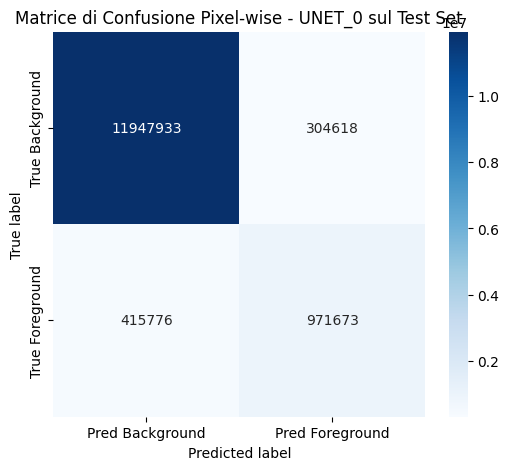

True Negatives: 11947933
False Positives: 304618
False Negatives: 415776
True Positives: 971673

Generazione Precision-Recall Curve...


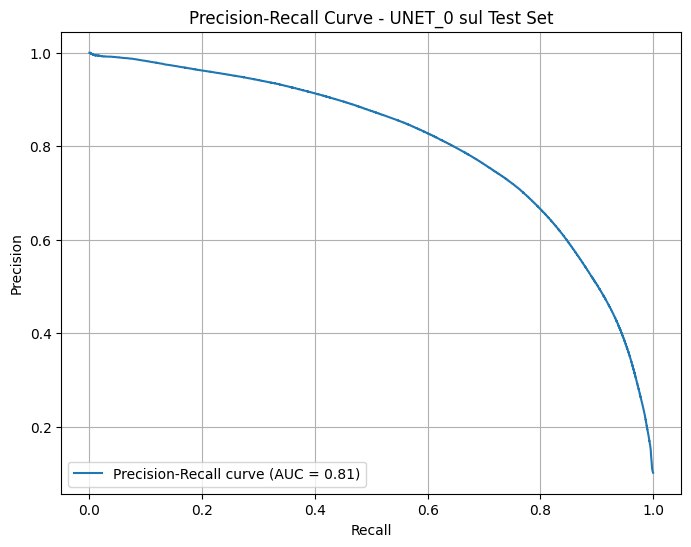

Precision-Recall AUC: 0.8054


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    print("\nGenerazione Matrice di Confusione Pixel-wise...")
    cm = compute_pixel_confusion_matrix(test_loader, model, device)
    print("\nMatrice di Confusione (Pixel-wise):\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Background', 'Pred Foreground'],
            yticklabels=['True Background', 'True Foreground'])
plt.title(f'Matrice di Confusione Pixel-wise - {best_run_id} sul Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    print("\nGenerazione Precision-Recall Curve...")
    plot_pr_curve(test_loader, model, device, title=f'Precision-Recall Curve - {best_run_id} sul Test Set')




Generazione Visualizzazioni Esempio...


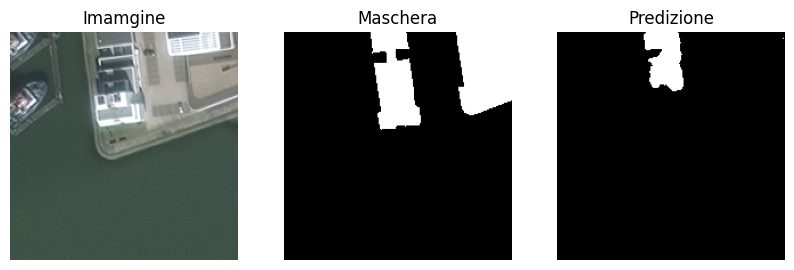

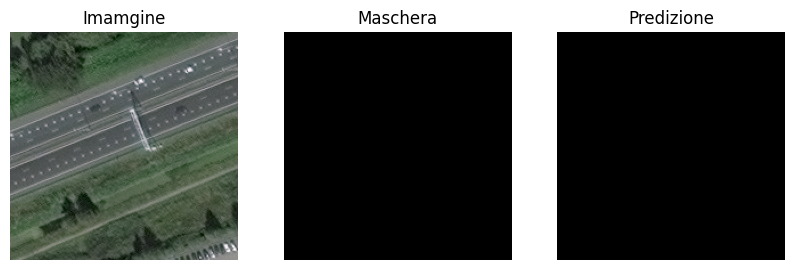


Fase di Test Completata!


In [36]:
print("\nGenerazione Visualizzazioni Esempio...")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
    image, mask, pred = utils.get_random_image(test_loader, model, device)
    utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = "output/test/" + "esempio0.png")
    image, mask, pred = utils.get_random_image(test_loader, model, device)
    utils.visualize_image(image.cpu(), mask.cpu(), pred.cpu(), save_path = "output/test/" + "esempio1.png")

print("\nFase di Test Completata!")